In [1]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

## Carga de Datos

In [116]:
data = pd.read_csv('data/homicidios.csv', na_values=['Unknown', ' '])

## Preparación de datos

In [117]:
data.shape

(638454, 24)

In [118]:
data.head().T

,0,1,2,3,4
Record ID,1,2,3,4,5
Agency Code,AK00101,AK00101,AK00101,AK00101,AK00101
Agency Name,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage
Agency Type,Municipal Police,Municipal Police,Municipal Police,Municipal Police,Municipal Police
City,Anchorage,Anchorage,Anchorage,Anchorage,Anchorage
State,Alaska,Alaska,Alaska,Alaska,Alaska
Year,1980,1980,1980,1980,1980
Month,January,March,March,April,April
Incident,1,1,2,1,2
Crime Type,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter,Murder or Manslaughter


In [119]:
data.columns

Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')

Se nesesita quitar las siguientes columnas : 
* Record ID : id de identificación
* Agency Code : id de agencia
* Perpetrator Ethnicity & Age : variable respuesta

In [120]:
cols_to_drop = ['Record ID', 'Agency Code', 'Perpetrator Ethnicity']
data_orig = data.copy()
data.drop(columns=cols_to_drop, inplace=True)
cols_to_drop = []

In [121]:
data['Crime Solved'].value_counts()

Yes    448172
No     190282
Name: Crime Solved, dtype: int64

In [122]:
data_orig = data.copy()
# data = data_orig

data = data[data['Crime Solved'] == 'Yes']
cols_to_drop += ['Crime Solved']

In [123]:
data['Perpetrator Age category'] = np.where(data['Perpetrator Age'] > 64, 'Elder', np.where(data['Perpetrator Age'] < 25, 'Young', 'Adult'))
# data['Victim Age category'] = np.where(data['Victim Age'] > 64, 'Elder', np.where(data['Victim Age'] < 25, 'Young', 'Adult'))

In [124]:
Y_columns = ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
ignore_columns = ['Crime Solved']
cat_columns = []
num_columns = []

for col in data.columns.values:
    if col in Y_columns+ignore_columns:
        continue
    elif data[col].dtypes == 'int64':
        num_columns += [col]
    else:
        cat_columns += [col]


### Manejo de nulos
* Númericos: mediana
* Categoricos : categoria "Missing value" 



In [125]:
median_val = pd.Series()
for col in num_columns:
    if col not in cols_to_drop:
        median_val[col] = data[col].median()

In [126]:
median_val

Year                 1995.0
Incident                2.0
Victim Age             30.0
Victim Count            0.0
Perpetrator Count       0.0
dtype: float64

In [127]:
def handle_missing_values(data, median_val):
    df = data.copy()
    for col in df:
        if col in median_val.index.values:
            df[col] = df[col].fillna(median_val[col])
        else:
            df[col] = df[col].fillna("Missing value")
    
    return df

In [128]:
data = handle_missing_values(data, median_val)

In [129]:
data.drop(cols_to_drop, axis=1, inplace=True)

### Encoding


In [130]:
cat_columns

['Agency Name',
 'Agency Type',
 'City',
 'State',
 'Month',
 'Crime Type',
 'Victim Sex',
 'Victim Race',
 'Victim Ethnicity',
 'Perpetrator Age',
 'Relationship',
 'Weapon',
 'Record Source']

In [131]:
categorical_features = cat_columns + ['Perpetrator Sex', 'Perpetrator Race', 'Perpetrator Age category']
# categorical_features = categorical_features 
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

del cat_columns

In [132]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le

#### Escalamiento



In [133]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

In [134]:
numerical_features

['Year', 'Incident', 'Victim Age', 'Victim Count', 'Perpetrator Count']

In [135]:
data[numerical_features]

,Year,Incident,Victim Age,Victim Count,Perpetrator Count
0,1980,1,14,0,0
1,1980,1,43,0,0
3,1980,1,43,0,0
5,1980,1,30,0,0
6,1980,2,42,0,0
...,...,...,...,...,...
638448,2014,1,29,0,0
638450,2014,1,62,0,0
638451,2014,1,0,0,0
638452,2014,1,55,0,1


In [136]:
numerical_features = [c for c in data.columns.values if c not in categorical_features]

for feature in numerical_features:
    val = data_encoded[feature].values[:, np.newaxis]
    mms = MinMaxScaler().fit(val)
    data_encoded[feature] = mms.transform(val)
    encoders[feature] = mms
    
data_encoded = data_encoded.astype(float)

del num_columns

In [137]:
data_encoded.head()

,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Victim Sex,Victim Age,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age category
0,146.0,1.0,35.0,1.0,0.0,4.0,0.001001,1.0,1.0,0.014028,...,1.0,1.0,15.0,3.0,0.0,0.0,0.0,0.0,0.0,2.0
1,146.0,1.0,35.0,1.0,0.0,7.0,0.001001,1.0,1.0,0.043086,...,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
3,146.0,1.0,35.0,1.0,0.0,0.0,0.001001,1.0,1.0,0.043086,...,1.0,1.0,42.0,4.0,0.0,14.0,0.0,0.0,0.0,0.0
5,146.0,1.0,35.0,1.0,0.0,8.0,0.001001,1.0,1.0,0.030060,...,1.0,1.0,36.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0
6,146.0,1.0,35.0,1.0,0.0,8.0,0.002002,1.0,0.0,0.042084,...,1.0,1.0,27.0,1.0,27.0,9.0,0.0,0.0,0.0,0.0


In [138]:
def decode_dataset(data, encoders, numerical_features, categorical_features):
    df = data.copy()
    for feat in df.columns.values:
        if feat in numerical_features:
            df[feat] = encoders[feat].inverse_transform(np.array(df[feat]).reshape(-1, 1))
    for feat in categorical_features:
        df[feat] = encoders[feat].inverse_transform(df[feat].astype(int))
    return df

In [139]:
decode_dataset(data_encoded, encoders=encoders, numerical_features=numerical_features, categorical_features=categorical_features).head()

,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,Victim Sex,Victim Age,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source,Perpetrator Age category
0,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,January,1.0,Murder or Manslaughter,Male,14.0,...,Missing value,Male,15.0,Native American/Alaska Native,Acquaintance,Blunt Object,0.0,0.0,FBI,Young
1,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,March,1.0,Murder or Manslaughter,Male,43.0,...,Missing value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
3,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,April,1.0,Murder or Manslaughter,Male,43.0,...,Missing value,Male,42.0,White,Acquaintance,Strangulation,0.0,0.0,FBI,Adult
5,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,1.0,Murder or Manslaughter,Male,30.0,...,Missing value,Male,36.0,White,Acquaintance,Rifle,0.0,0.0,FBI,Adult
6,Anchorage,Municipal Police,Anchorage,Alaska,1980.0,May,2.0,Murder or Manslaughter,Female,42.0,...,Missing value,Male,27.0,Black,Wife,Knife,0.0,0.0,FBI,Adult


## AIF360

In [26]:
data_perp_sex = data_encoded.drop(['Perpetrator Race','Perpetrator Age category','Perpetrator Age'], axis=1)

In [27]:
privileged_sex = np.where(categorical_names['Victim Sex'] == 'Male')[0]
privileged_race = np.where(categorical_names['Victim Race'] == 'White')[0]

In [140]:
data_orig_sex = StandardDataset(data_perp_sex, 
                               label_name='Perpetrator Sex', 
                               favorable_classes=[1], 
                               protected_attribute_names=['Victim Sex', 'Victim Race'], 
                               privileged_classes=[privileged_sex, privileged_race])

In [141]:
def meta_data(dataset):
    # print out some labels, names, etc.
    display(Markdown("#### Dimenciones"))
    print(dataset.features.shape)
    display(Markdown("#### Etiquetas de Favorable y Desfavorable"))
    print(dataset.favorable_label, dataset.unfavorable_label)
    display(Markdown("#### Nombre de los atributos protegidos"))
    print(dataset.protected_attribute_names)
    display(Markdown("#### Valores de los atributos privelegiados y no privelegiados"))
    print(dataset.privileged_protected_attributes, dataset.unprivileged_protected_attributes)
    display(Markdown("#### Nombre de las caracteristicas"))
    print(dataset.feature_names)

In [142]:
meta_data(data_orig_sex)

#### Dimenciones

(448172, 17)


#### Etiquetas de Favorable y Desfavorable

1.0 0.0


#### Nombre de los atributos protegidos

['Victim Sex', 'Victim Race']


#### Valores de los atributos privelegiados y no privelegiados

[array([1.]), array([4.])] [array([0., 2.]), array([0., 1., 2., 3.])]


#### Nombre de las caracteristicas

['Agency Name', 'Agency Type', 'City', 'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity', 'Relationship', 'Weapon', 'Victim Count', 'Perpetrator Count', 'Record Source']


### Modelamiento

In [31]:
np.random.seed(42)

data_orig_sex_train, data_orig_sex_test = data_orig_sex.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print("Sexo del perpetrador :",data_orig_sex_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print("Sexo del perpetrador  :",data_orig_sex_test.features.shape)

#### Train Dataset shape

Sexo del perpetrador : (313720, 17)


#### Test Dataset shape

Sexo del perpetrador  : (134452, 17)


In [152]:
orig_sex_train.labels.ravel()

NameError: name 'orig_sex_train' is not defined

In [143]:
rf_orig_sex = RandomForestClassifier().fit(data_orig_sex_train.features, 
                     data_orig_sex_train.labels.ravel(), 
                     sample_weight=data_orig_sex_train.instance_weights)

### Predict on test set

In [144]:
X_test_sex = data_orig_sex_test.features
y_test_sex = data_orig_sex_test.labels.ravel()

In [160]:
type(y_test_sex)

numpy.ndarray

In [159]:
y_test_sex.value_counts()

AttributeError: 'numpy.ndarray' object has no attribute 'value_counts'

### Performance of the model

In [145]:
def get_model_performance(X_test, y_true, y_pred, probs):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)

    return accuracy, matrix, f1, fpr, tpr, roc_auc

def plot_model_performance(model, X_test, y_true):
    y_pred = model.predict(X_test)
    probs = model.predict_proba(X_test)
    accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

    display(Markdown('#### Accuracy of the model :'))
    print(accuracy)
    display(Markdown('#### F1 score of the model :'))
    print(f1)

    fig = plt.figure(figsize=(15, 6))
    ax = fig.add_subplot(1, 2, 1)
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')

    ax = fig.add_subplot(1, 2, 2)
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")

#### Accuracy of the model :

0.9349582006961592


#### F1 score of the model :

0.9645717619319633


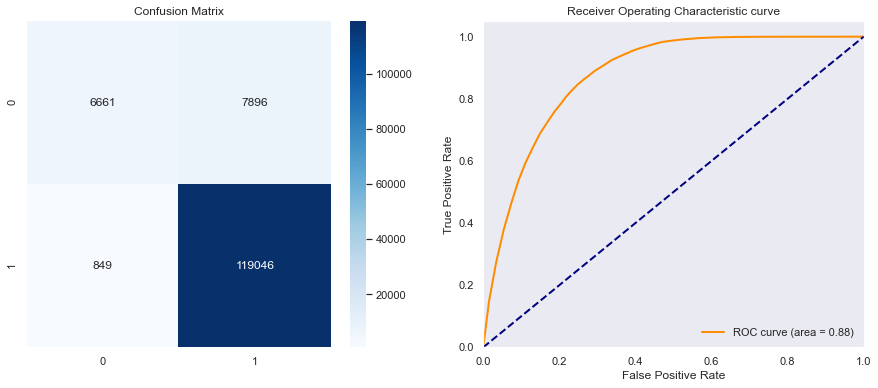

In [146]:
plot_model_performance(rf_orig_sex, data_orig_sex_test.features, y_test_sex)


## Sesgos



### Metricas

* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### <a id='4.1.1'>4.1.1 Statistical Parity Difference</a>


$$ Pr(Y=1|D=Noprivilegiado) - Pr(Y=1|D=privilegiado) $$


Más detalles en : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### <a id='4.1.2'>4.1.2 Equal Opportunity Difference</a>


$$ TPR_{D=Noprivilegiado} - TPR_{D=privilegiado} $$ 

#### <a id='4.1.3'>4.1.3 Average Absolute Odds Difference</a>


$$ \frac{1}{2}[|FPR_{D=Noprivilegiado} - FPR_{D=privilegiado} | + | TPR_{D=Noprivilegiado} - TPR_{D=privilegiado}|]$$


#### <a id='4.1.4'>4.1.4 Disparate Impact</a>


$$ \frac{Pr(Y=1|D=Noprivilegiado)}{Pr(Y=1|D=privilegiado)} $$



#### <a id='4.1.5'>4.1.5 Theil </a>


$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

donde $b_i = \hat{y}_i - y_i + 1 $


* Equal Opportunity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference)
   
`equal_opportunity_difference()`
* Average Absolute Odds Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference)

`average_abs_odds_difference()`
* Theil Index : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index)

`theil_index()`

Then for the metrics that don't require prediction (the second class) we can use them with the following functions : 
* Statistical Parity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference)

`statistical_parity_difference()`
* Disparate Impact : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact)

`disparate_impact()`




In [170]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

In [148]:
def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [149]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Metricas de Sesgos", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Metricas de sesgos :"))
    display(Markdown("Un modelo se puede considerar sesgado si una de las 5 metricas lo revela"))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### Para el atributo %s  :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("Con umbrales por defecto, sesgo contra grupo no privilegiado detectado en **%d** de las 5 metricas"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [150]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

### Metricas de sesgo para el sexo en el modelo

### Metricas de sesgos :

Un modelo se puede considerar sesgado si una de las 5 metricas lo revela

#### Para el atributo Victim Sex  :

Con umbrales por defecto, sesgo contra grupo no privilegiado detectado en **1** de las 5 metricas

#### Para el atributo Victim Race  :

Con umbrales por defecto, sesgo contra grupo no privilegiado detectado en **0** de las 5 metricas

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
Victim Sex,0.028350,-0.007058,0.141002,1.030251,0.026273
Victim Race,0.009641,-0.002116,0.017783,1.010131,0.026273


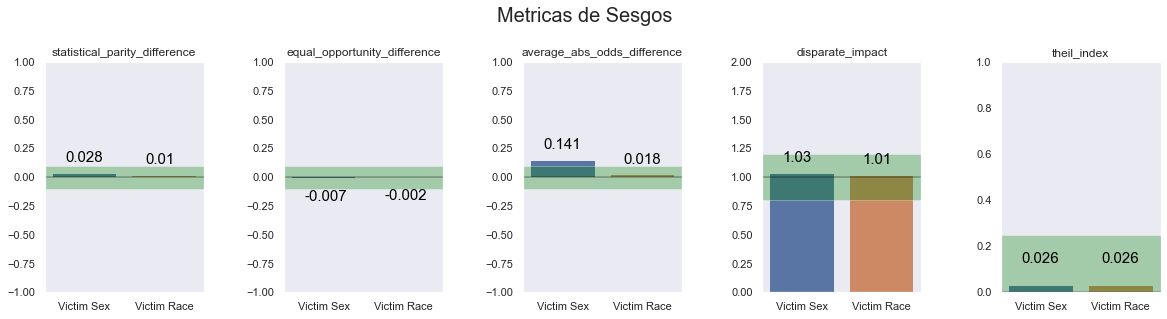

In [151]:
display(Markdown('### Metricas de sesgo para el sexo en el modelo'))
fair = get_fair_metrics_and_plot(data_orig_sex_test, rf_orig_sex)

In [161]:
data_orig_test = data_orig_sex_test
data_orig_train = data_orig_sex_train
rf = rf_orig_sex

probs = rf.predict_proba(data_orig_test.features)
preds = rf.predict(data_orig_test.features)


In [171]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf, fair, preds, probs, 'Origin')


### Correción de Sesgos

AIF360 usa 3 tipos de algoritmos :
* Pre-processing algorithms 
* In-processing algorithms 
* Post-processing algorithms 


Este es el **fairness pipeline**. Una instanciación de ejemplo de esta canalización genérica consiste en cargar datos en un objeto de conjunto de datos, transformandoen un conjunto de datos más justo utilizando un algoritmo de preprocesamiento justo, aprendiendo un clasificador de este conjunto de datos transformado y obteniendo predicciones de este clasificador. Las métricas se pueden calcular en los conjuntos de datos originales, transformados y predichos, así como entre losconjuntos de datos transformados y pronosticados. También son posibles muchas otras instancias (más información en [the aif360 paper](https://arxiv.org/pdf/1810.01943.pdf)).

####  Pre-processing algorithms 

Hay 4 algoritmos de preprocesamiento, pero para 3 de ellos **hay un problema**: funcionará solo si el conjunto de datos tiene un atributo protegido, pero aquí tenemos 2: * Sexo * y * Raza *. Pero hagamos una introducción rápida para todos ellos

Debido a que este cuaderno es una exploración de la equidad en los modelos, solo usaré 1 atributo protegido: Victim Race, me permitirá usar casi todos los algoritmos (pero para su información, el algoritmo * Reweighing * puede funcionar con todos los protegidos, por eso creará una función que me proporcione los atributos protegidos y desprotegidos.

Puede encontrar toda la información del código en [the documentation](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#)



In [41]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names
    
    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 

    return privileged_groups, unprivileged_groups

*****
##### Eliminador de impacto desigual 
Fuente: [Feldman et al., 2015] (https://dl.acm.org/citation.cfm?doid=2783258.2783311)

El eliminador de impactos dispares es una técnica de preprocesamiento que edita los valores de las características y aumenta la equidad del grupo al tiempo que conserva el orden de clasificación dentro de los grupos.
Si desea ver cómo funciona, puede echar un vistazo a [un ejemplo de Notebook de GitHub de AIF360] (https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).

Algún ejemplo de código:
''
de aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover ()
data_transf_train = DIR.fit_transform (data_orig_train)
''
*****
##### Aprendiendo representaciones justas 
Fuente: [Zemel et al., 2013] (http://proceedings.mlr.press/v28/zemel13.html)

El aprendizaje de representaciones justas es una técnica de preprocesamiento que encuentra una representación latente que codifica bien los datos pero que confunde la información sobre los atributos protegidos.
Puede encontrar más información en [el cuaderno de demostración] (https://github.com/IBM/AIF360/blob/master/examples/demo_lfr.ipynb).

In [42]:
from aif360.algorithms.preprocessing.lfr_helpers import helpers as lfr_helpers

In [43]:
LFR

aif360.algorithms.preprocessing.lfr.LFR

In [44]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

print('time elapsed : %.2fs'%(time()-t0))

250 73710019528.56781
500 73709989347.90424
time elapsed : 60.14s


In [110]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'LFR')


*****
##### Optimized preprocessing
fuente : [Calmon et al., 2017](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention)

El preprocesamiento optimizado es una técnica de preprocesamiento que aprende una transformación probabilística que edita las características y etiquetas en los datos con equidad de grupo, distorsión individual y restricciones y objetivos de fidelidad de datos.
[a demo notebook on the aif360 GitHub](https://github.com/IBM/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb).

*****
##### Reweighing
fuente : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Volver a pesar es una técnica de preprocesamiento que pondera los ejemplos en cada combinación (grupo, etiqueta) de forma diferente para garantizar la equidad antes de la clasificación. 

In [163]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)

print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 80.13s


In [172]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')


In [166]:
algo_metrics

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.2, 0.8], [0.02, 0.98], [0.04, 0.96], [0.05..."
Reweighing,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.14, 0.86], [0.0, 1.0], [0.04, 0.96], [0.01..."


#### In-processing algorithms

[documentacion](https://aif360.readthedocs.io/en/latest/modules/inprocessing.html)
*****
#####   Adversarial Debiasing
Source : [Zhang et al., 2018](http://www.aies-conference.com/wp-content/papers/main/AIES_2018_paper_162.pdf)

El desvanecimiento adversario es una técnica en proceso que aprende un clasificador para maximizar la precisión de la predicción y, al mismo tiempo, reducir la capacidad de un adversario para determinar el atributo protegido a partir de las predicciones. Este enfoque conduce a un clasificador justo, ya que las predicciones no pueden llevar ninguna información de discriminación de grupo que el adversario pueda explotar.

In [49]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

# sess.close()
# tf.reset_default_graph()
sess = tf.Session()

debiased_model = AdversarialDebiasing(privileged_groups = privileged_groups,
                          unprivileged_groups = unprivileged_groups,
                          scope_name='debiased_classifier',
                          num_epochs=10,
                          debias=True,
                          sess=sess)

debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'AdvDebiasing')
print('time elapsed : %.2fs'%(time()-t0))

AttributeError: module 'tensorflow' has no attribute 'Session'

*****
##### <a id='4.2.2.2'>4.2.2.2 Prejudice Remover Regularizer</a>
fuente: [Kamishima et al., 2012](https://rd.springer.com/chapter/10.1007/978-3-642-33486-3_3)

El eliminador de prejuicios es una técnica de procesamiento que agrega un término de regularización consciente de la discriminación al objetivo de aprendizaje.

In [50]:
t0 = time()
debiased_model = PrejudiceRemover(sensitive_attr="Victim Race", eta = 25.0)
debiased_model.fit(data_orig_train)

fair = get_fair_metrics_and_plot(data_orig_test, debiased_model, plot=False, model_aif=True)
data_pred = debiased_model.predict(data_orig_test)

print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 611.06s


In [167]:
#algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')


In [168]:
algo_metrics

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.2, 0.8], [0.02, 0.98], [0.04, 0.96], [0.05..."
Reweighing,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.14, 0.86], [0.0, 1.0], [0.04, 0.96], [0.01..."
PrejudiceRemover,<aif360.algorithms.inprocessing.prejudice_remo...,statistical_parity_difference eq...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.873490045540826], [0.9362436007571817], [0..."


#### Post-processing algorithms

In [51]:
data_orig_test_pred = data_orig_test.copy(deepcopy=True)

# Prediction with the original RandomForest model
scores = np.zeros_like(data_orig_test.labels)
scores = rf.predict_proba(data_orig_test.features)[:,1].reshape(-1,1)
data_orig_test_pred.scores = scores

preds = np.zeros_like(data_orig_test.labels)
preds = rf.predict(data_orig_test.features).reshape(-1,1)
data_orig_test_pred.labels = preds

def format_probs(probs1):
    probs1 = np.array(probs1)
    probs0 = np.array(1-probs1)
    return np.concatenate((probs0, probs1), axis=1)

*****
##### Calibrated Equality of Odds
fuente : [Pleiss et al., 2017](https://papers.nips.cc/paper/7151-on-fairness-and-calibration)

El posprocesamiento de probabilidades igualadas calibradas es una técnica de posprocesamiento que optimiza las salidas de puntuación del clasificador sobre calibrado para encontrar probabilidades con las que cambiar las etiquetas de salida con un objetivo de probabilidades igualadas.

In [180]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

cost_constraint = "fnr" # "fnr", "fpr", "weighted"

CPP = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=42)

CPP = CPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = CPP.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_orig_test_pred, pred_is_dataset=True)


print('time elapsed : %.2fs'%(time()-t0))

time elapsed : 1.92s


In [181]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      CPP, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'CalibratedEqOdds')

In [182]:
algo_metrics

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.14, 0.86], [0.0, 1.0], [0.04, 0.96], [0.01..."
Reweighing,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.14, 0.86], [0.0, 1.0], [0.04, 0.96], [0.01..."
CalibratedEqOdds,<aif360.algorithms.postprocessing.calibrated_e...,statistical_parity_difference eq...,"[[1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1....","[[0.22999999999999998, 0.77], [0.0, 1.0], [0.0..."


In [ ]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, debiased_model, fair, data_pred.labels, data_pred.scores, 'PrejudiceRemover')


*****
##### Equality of Odds
fuente : [Hardt et al., 2016](https://papers.nips.cc/paper/6374-equality-of-opportunity-in-supervised-learning)

El posprocesamiento de probabilidades igualadas es una técnica de posprocesamiento que resuelve un programa lineal para encontrar probabilidades con las que cambiar las etiquetas de salida para optimizar las probabilidades igualadas.


Algún ejemplo de código:
```
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
EOPP = EqOddsPostprocessing(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups,
                             seed=42)
EOPP = EOPP.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = EOPP.predict(data_orig_test_pred)
```

*****
##### Reject Option Classification
fuente : [Kamishima et al., 2012](https://ieeexplore.ieee.org/document/6413831/)

La clasificación de opciones de rechazo es una técnica de posprocesamiento que da resultados favorables a los grupos desfavorecidos y resultados desfavorables a los grupos privilegiados en una banda de confianza alrededor del límite de decisión con la mayor incertidumbre.

In [53]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['Victim Race'])
t0 = time()

ROC = RejectOptionClassification(privileged_groups = privileged_groups,
                             unprivileged_groups = unprivileged_groups)

ROC = ROC.fit(data_orig_test, data_orig_test_pred)
data_transf_test_pred = ROC.predict(data_orig_test_pred)

fair = fair_metrics(data_orig_test, data_transf_test_pred, pred_is_dataset=True)


print('time elapsed : %.2fs'%(time()-t0))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
algo_metrics = add_to_df_algo_metrics(algo_metrics, 
                                      ROC, 
                                      fair, 
                                      data_transf_test_pred.labels, 
                                      format_probs(data_transf_test_pred.scores), 
                                      'RejectOption')

### Comparación de todos los algoritmos con 1 atributo

In [90]:
def plot_fair_metrics_plotly(fair_metrics):
    bottom = [-1, -1, -1, 0, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]
    cols = fair_metrics.columns.values

    for i in range(0, 5):
        col = cols[i]

        x, y = (fair_metrics[col].values, fair_metrics.index)
        colors = []
        for v in x:
            color = '#e74c3c' if v < min_valid[i] or v > max_valid[i] else '#2ecc71'
            colors.append(color)

        trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                       , opacity=0.9, orientation='h')

        layout = go.Layout(barmode='group',
                           title=col,
                           xaxis=dict(range=[bottom[i], bottom[i] + 2]),
                           yaxis=go.layout.YAxis(automargin=True),
                           shapes=[
                               {
                                   'type': 'line',
                                   'x0': min_valid[i],
                                   'y0': -1,
                                   'x1': min_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }, {
                                   'type': 'line',
                                   'x0': max_valid[i],
                                   'y0': -1,
                                   'x1': max_valid[i],
                                   'y1': len(y),
                                   'line': {
                                       'color': 'rgb(0, 0, 0)',
                                       'width': 2,
                                   },
                               }])
        fig = go.Figure([trace], layout=layout)
        py.iplot(fig)


def plot_score_fair_metrics(score):
    display(score.sort_values(['nb_valid', 'score'], ascending=[0, 1]))
    score.sort_values(['nb_valid', 'score'], ascending=[1, 0], inplace=True)

    gold, silver, bronze, other = ('#FFA400', '#bdc3c7', '#cd7f32', '#3498db')
    colors = [gold if i == 0 else silver if i == 1 else bronze if i == 2 else other for i in range(0, len(score))]
    colors = [c for c in reversed(colors)]

    x, y = (score['score'].values, score.index)

    trace = go.Bar(x=x, y=y, marker=dict(color=colors)
                   , opacity=0.9, orientation='h')
    layout = go.Layout(barmode='group',
                       title='Fairest algorithm',
                       yaxis=go.layout.YAxis(automargin=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    

def score_fair_metrics(fair):
    objective = [0, 0, 0, 1, 0]
    max_valid = [0.1, 0.1, 0.1, 1.2, 0.25]
    min_valid = [-0.1, -0.1, -0.1, 0.8, 0]

    nb_valid = np.sum(((fair.values > min_valid) * (fair.values < max_valid)), axis=1)
    score = np.sum(np.abs(fair.values - objective), axis=1)
    score = np.array([score, nb_valid])

    score = pd.DataFrame(data=score.transpose(), columns=['score', 'nb_valid'], index=fair.index)
    return score


def score_all_attr(algo_metrics):
    attributes = algo_metrics.loc['Origin', 'fair_metrics'].index.values[1:]

    all_scores = np.zeros((len(algo_metrics), 2))
    for attr in attributes:
        df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin', 'fair_metrics'].columns.values)
        for fair in algo_metrics.loc[:, 'fair_metrics']:
            df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)
        all_scores = all_scores + score_fair_metrics(df_metrics).values

    final = pd.DataFrame(data=all_scores, columns=['score', 'nb_valid'], index=algo_metrics.index)
    return final


In [91]:
def compare_fair_metrics(algo_metrics, attr='Victim Race'):
    
    df_metrics = pd.DataFrame(columns=algo_metrics.loc['Origin','fair_metrics'].columns.values)
    for fair in algo_metrics.loc[:,'fair_metrics']:
        df_metrics = df_metrics.append(fair.loc[attr], ignore_index=True)

    df_metrics.index = algo_metrics.index.values
    df_metrics = df_metrics.replace([np.inf, -np.inf], np.NaN)
    
    display(df_metrics)
    plot_fair_metrics_plotly(df_metrics)
    score = score_fair_metrics(df_metrics)
    plot_score_fair_metrics(score.dropna())

In [183]:
compare_fair_metrics(algo_metrics)

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
Origin,0.012204,0.000855,0.016193,1.012821,0.026197
Reweighing,0.012204,0.000855,0.016193,1.012821,0.026197
CalibratedEqOdds,0.010632,-0.000615,0.014966,1.011168,0.026100


,score,nb_valid
CalibratedEqOdds,0.063481,5.0
Origin,0.068271,5.0
Reweighing,0.068271,5.0


### Comparación de resndimiento de los algorotmos

In [93]:
algo_metrics

,model,fair_metrics,prediction,probs
Origin,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.23, 0.77], [0.0, 1.0], [0.04, 0.96], [0.04..."
LFR,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.23, 0.77], [0.0, 1.0], [0.04, 0.96], [0.04..."
Reweighing,"(DecisionTreeClassifier(ccp_alpha=0.0, class_w...",statistical_parity_difference eq...,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[[0.23, 0.77], [0.0, 1.0], [0.04, 0.96], [0.04..."
PrejudiceRemover,<aif360.algorithms.inprocessing.prejudice_remo...,statistical_parity_difference eq...,"[[1.0], [1.0], [1.0], [1.0], [1.0], [1.0], [1....","[[0.873490045540826], [0.9362436007571817], [0..."
CalibratedEqOdds,<aif360.algorithms.postprocessing.calibrated_e...,statistical_parity_difference eq...,"[[1.0], [1.0], [1.0], [0.0], [1.0], [1.0], [1....","[[0.22999999999999998, 0.77], [0.0, 1.0], [0.0..."


In [94]:
algo_metrics.loc['Origin', 'prediction']

array([1., 1., 1., ..., 1., 1., 1.])

In [95]:
data_orig_test

               instance weights    features                            \
                                                                        
                                Agency Name Agency Type    City State   
instance names                                                          
394228                      1.0      1012.0         1.0   484.0  20.0   
552111                      1.0      1877.0         1.0   459.0   5.0   
100986                      1.0      3420.0         1.0   702.0  43.0   
111870                      1.0      1933.0         1.0  1688.0  22.0   
464034                      1.0      3984.0         1.0  1691.0  43.0   
...                         ...         ...         ...     ...   ...   
366846                      1.0      4909.0         1.0  1699.0  32.0   
520882                      1.0      4044.0         3.0   912.0   9.0   
180365                      1.0      1532.0         1.0   942.0   4.0   
201251                      1.0      4224.0        

In [174]:
def plot_compare_model_performance(algo_metrics, dataset):
    X_test = dataset.features
    y_true = dataset.labels
    perf_metrics = pd.DataFrame()

    models_name = algo_metrics.index.values

    fig = plt.figure(figsize=(7, 7))
    plt.title('ROC curve for differents models')
    lw = 2
    palette = sns.color_palette("Paired")

    for model_name, i in zip(models_name, range(0, len(models_name))):
        model = algo_metrics.loc[model_name, 'model']

        if model_name != 'AdvDebiasing':
            probs = algo_metrics.loc[model_name, 'probs']
            y_pred = algo_metrics.loc[model_name, 'prediction']
            accuracy, matrix, f1, fpr, tpr, roc_auc = get_model_performance(X_test, y_true, y_pred, probs)

            perf_metrics = perf_metrics.append(
                pd.DataFrame([[accuracy, f1]], columns=['Accuracy', 'F1 Score'], index=[model_name]))
            plt.plot(fpr, tpr, color=palette[i], lw=lw, label=str(model_name) + ' (area = %0.2f)' % roc_auc)

    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    display(perf_metrics.sort_values(by=['Accuracy', 'F1 Score'], ascending=[False, False]))
    plt.show()

In [175]:
 y_true = data_orig_test.labels

In [176]:
y_true.shape

(134452, 1)

In [177]:
y_pred = algo_metrics.loc['Reweighing', 'prediction']
y_pred.shape


(134452,)

,Accuracy,F1 Score
Origin,0.934847,0.964519
Reweighing,0.934847,0.964519
CalibratedEqOdds,0.552547,0.678577


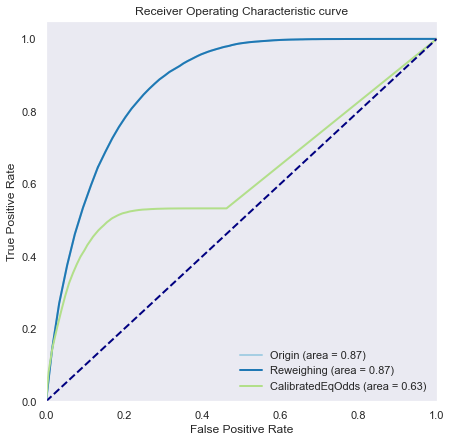

In [184]:
plot_compare_model_performance(algo_metrics, data_orig_test)